## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [ ]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

# 0 Importing required modules

In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from mlxtend.feature_selection import SequentialFeatureSelector
import tensorflow as tf
import re
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import normaltest


# 1 Preparing and Processing Data

## 1.1 Reading Data

In [211]:
#Read dataset
data = pd.read_parquet('catB_train.parquet')
df = data.copy()

#set random state
RANDOM_STATE = 7

## 1.2 Removing Certain Variables

- Variables with only one value (including NAs) and all similar variables relating to those specific dropped insurance policies
- Client number variable
- Variables with large number of NA values (ie. 12592)
- Variables with moderate to high multicollinearity (please refer to the appendix for the specific VIF values)

In [213]:
## Removing columns with only one value
to_drop = df.columns[df.nunique(dropna=False) == 1]
df = df.drop(columns=to_drop)
#df.shape #(17992, 247)

#For those variables that have been dropped earlier,
#Find other variables relating to those specific insurance policies
#And drop them
to_drop_2_setup = []
for var in to_drop:
    if "ape" in var[0:3]:
        to_drop_2_setup.append(var[4:])

to_drop_2_setup.remove("gi") #Manually remove
#to_drop_2_setup

to_drop_2 = []
for var in list(df.columns):
    for drop_var_part in to_drop_2_setup:
        if drop_var_part in var:
            to_drop_2.append(var)
to_drop_2
df = df.drop(columns = to_drop_2)

#Drop client number as its not required
df = df.drop(columns = "clntnum")

#12592 Nones, for all the lapse variables --> Drop them all!
cols_with_many_nones = []
for var in list(df.columns):
    if None in df[var].value_counts(dropna=False):
        if df[var].value_counts(dropna=False)[None] == 12592:
            cols_with_many_nones.append(var)
df = df.drop(columns=cols_with_many_nones)

In [214]:
#Remove features displaying multicollinearity
multicollinearity_features = ["is_consent_to_mail",
                              "is_consent_to_email",
                              "is_sg_pr",
                              "hh_20",
                              "hh_size_est",
                              "pop_20",
                              "recency_hlthclaim",
                              "recency_giclaim"]

df = df.drop(columns=multicollinearity_features)

## 1.3 Converting Variables to the Correct Type

In [215]:
#Convert to datetime
df["cltdob_fix"] = pd.to_datetime(df["cltdob_fix"], errors="coerce")
df["min_occ_date"] = pd.to_datetime(df["min_occ_date"], errors="coerce")

#Convert from string to numerics (int or float)
def coerce_to_numeric(value):
    try:
        return pd.to_numeric(value)
    except (ValueError, TypeError):
        return value
df = df.applymap(coerce_to_numeric)

C:\Users\yeosh\AppData\Local\Temp\ipykernel_19212\3108799698.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(coerce_to_numeric)


## 1.4 Dealing with NA Values

In [216]:
#Function to replace NaN values proportionally with the other values, referenced from https://stackoverflow.com/questions/51213202/replace-nan-with-existing-values-proportionately response by Maxim Dsouza

def replace_with_proportion(frame, column):

     isnull = frame[column].isnull()
     sample = frame[column].dropna()
     sample=set(sample)
     countframe=pd.DataFrame(columns=["name", "count", "proportion"])
     for x in sample:
          countframe.loc[-1] = [x,frame.loc[frame[column] == x].shape[0], 0 ]
          countframe.index = countframe.index + 1
     countframe['proportion']=countframe['count']/countframe['count'].sum()
     to_fill=np.random.choice(countframe['name'], size=(frame[column].isnull().sum(),), p=countframe['proportion'])
     frame.loc[isnull, column] = to_fill

     return frame


In [217]:
#Target variable --> Fill with 0
df["f_purchase_lh"].fillna(0, inplace=True)

C:\Users\yeosh\AppData\Local\Temp\ipykernel_19212\3493999262.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["f_purchase_lh"].fillna(0, inplace=True)


### 1.4.1 Replace with Proportion

In [218]:
df = replace_with_proportion(df, 'race_desc')

df = replace_with_proportion(df, 'cltsex_fix')

df = replace_with_proportion(df, 'annual_income_est')

### 1.4.2 Handling NA in numeric binary features

In [219]:
binary_features_0_1 = []
binary_features_0_only = []
binary_features_1_only = []

for col in df.columns:
    unique_values = set(df[col].dropna().unique())

    if unique_values == {0, 1}:
        binary_features_0_1.append(col)
    elif unique_values == {0}:
        binary_features_0_only.append(col)
    elif unique_values == {1}:
        binary_features_1_only.append(col)

# If both 0 and 1 values already exist, replace proportionally 
for col in binary_features_0_1:
    replace_with_proportion(df, col)

# If only 1 exists, assume the NAs are 0s that were never filled in 
for col in binary_features_1_only:
    df[col].fillna(0, inplace = True)

# binary_features_0_only = ["is_dependent_in_at_least_1_policy"]
# is_dependent_in_at_least_1_policy --> Cannot assume that 1014 NAs are any value
# If filled with 0, then all values in the variable are 0.
# Thus, can remove this variable
df.drop(columns = ["is_dependent_in_at_least_1_policy"], inplace = True)

C:\Users\yeosh\AppData\Local\Temp\ipykernel_19212\892130482.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace = True)


### 1.4.3 Handling NA in other numeric features

In [220]:
#recency_lapse, recency_cancel, tot_cancel_pols --> put 0
df["recency_lapse"].fillna(0, inplace = True)
df["recency_cancel"].fillna(0, inplace = True)
df["tot_cancel_pols"].fillna(0, inplace = True)

general = ["affcon_visit_days",
            "clmcon_visit_days",
            "hlthclaim_amt",
            "hlthclaim_cnt_success",
            "hlthclaim_cnt_unsuccess",
            "giclaim_amt"
            ]

recencies = ["n_months_since_visit_affcon",
             "recency_clmcon",
             "recency_clmcon_regis",
             "recency_hlthclaim_success",
             "recency_hlthclaim_unsuccess",
             "recency_hlthclaim_839f8a",
             "recency_hlthclaim_14cb37"
             ]

# Replace with 0, indicating they were never performed
for var in general:
    df[var].fillna(0, inplace = True)

# Replace with an arbitrarily big value, indicating it has been very long
for var in recencies:
    df[var].fillna(9999, inplace = True)

# Preparation work before replacing remaining numeric features' NA values with either mean or median
all_binary_features = binary_features_0_1 + binary_features_0_only + binary_features_1_only
features_to_exclude = ["recency_lapse", "recency_cancel", "tot_cancel_pols"] + general + recencies
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
relevant_cols = []

# If feature is normally distributed --> replace with mean 
# Else --> replace with median
for col in numeric_cols:
    if col not in all_binary_features and col not in features_to_exclude:
        relevant_cols.append(col)
        stat, p_value = normaltest(df[col])
        if p_value > 0.05:
            df[col] = df[col].fillna(df[col].mean())
        else:
            df[col] = df[col].fillna(df[col].median())

C:\Users\yeosh\AppData\Local\Temp\ipykernel_19212\1290512521.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["recency_lapse"].fillna(0, inplace = True)
C:\Users\yeosh\AppData\Local\Temp\ipykernel_19212\1290512521.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

### 1.4.4 Replace with NA

In [221]:
df["ctrycode_desc"].fillna("Not Applicable", inplace = True)

C:\Users\yeosh\AppData\Local\Temp\ipykernel_19212\667859835.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ctrycode_desc"].fillna("Not Applicable", inplace = True)


### 1.4.5 NA datetime values replaced with median

Since the dataset is not ordered, forward or backward fill cannot be used for NA datetime values. Replaced with median values because datetime columns, unlike numerical columns, lack a natural order for calculating central tendencies such as mean or median. The use of the median datetime value was a neutral imputation strategy.


In [222]:
df["min_occ_date"].fillna(df["min_occ_date"].median(), inplace = True)

df["cltdob_fix"].fillna(df["cltdob_fix"].median(), inplace = True)

C:\Users\yeosh\AppData\Local\Temp\ipykernel_19212\287689985.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["min_occ_date"].fillna(df["min_occ_date"].median(), inplace = True)
C:\Users\yeosh\AppData\Local\Temp\ipykernel_19212\287689985.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

# 2 Exploratory Data Analysis

## 2.1 Functions used for producing graphs and statistical tests

In [223]:
#returns a table containing mean, median, mode and range values of columns
def calculate_statistics(column):
    mean_value = column.mean()
    median_value = column.median()
    mode_value = column.mode().iloc[0] if not column.mode().empty else np.nan
    range_value = column.max() - column.min()

    return pd.Series([mean_value, median_value, mode_value, range_value],
                     index=['Mean', 'Median', 'Mode', 'Range'])

def summary_table(columns):
    return df[columns_to_include].apply(calculate_statistics).transpose()

#returns skewness values of columns
def skewness(columns):
    skewness_table = df[columns_to_include].skew()
    return skewness_table.to_frame(name='Skewness')

#functions for scatter plot and histogram
def scatter_plot(x, y):
    sns.regplot(x=x, y=y, data=df, scatter=True, color='blue', label='Data Points', scatter_kws={'s':5}, line_kws={'color': 'black', 'linestyle': '--'})

    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.title(f'Scatter Plot of {y} against {x}')

    plt.legend()
    plt.show()

# Histogram (frequency counts for one variable)
def histogram(x, no_of_bins):
    sns.histplot(x=x, data=df, bins=no_of_bins, kde=True)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram showing {x}')

    # plt.grid(True)
    plt.show()

# 2D kernel stacked density plot
## for comparing continuous data against categorical data
def density_plot(x, hue):
    sns.kdeplot(data=df, x=x, hue=hue, multiple="fill", ec="white")

#creating a scatter plot with hue
def scatter_plot_with_hue(x, y, hue):
    g = sns.FacetGrid(df, hue=hue)
    g.map_dataframe(sns.scatterplot, x=x, y=y, s=15)
    g.add_legend()

#calculates correlation coeeficient between two continuous variables
def correlate(x, y):
    correlation = df[x].corr(df[y])
    print(f"Correlation between {x} and {y}:", correlation)


#chi square test between two categorical variables
def chi_square_test(data, column1, column2):
    # Create a contingency table
    contingency_table = pd.crosstab(data[column1], data[column2])
    print(contingency_table)

    # Perform Chi-square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

    #return chi2_stat, p_val, dof, expected
    if (p_val < 0.05):
        print(f'The p-value is {p_val:.20f}. At 5% level of significance, we reject the null hypothesis and conclude that there is significant association between {column1} and {column2}')
    else:
        print(f'The p-value is {p_val:.20f}. At 5% level of significance, we do not reject the null hypothesis and conclude that there is insignificant association between {column1} and {column2}')


## 2.2 Univariate Analysis

In [224]:
columns_to_include = ['n_months_last_bought_products', 'recency_lapse', 'recency_cancel', 'tot_inforce_pols', 'tot_cancel_pols', 'affcon_visit_days', 'n_months_since_visit_affcon', 'clmcon_visit_days', 'recency_clmcon', 'recency_clmcon_regis','hlthclaim_cnt_success']

In [225]:
summary_table(columns_to_include) #shows mean, median, mode and range of selected columns

,Mean,Median,Mode,Range
n_months_last_bought_products,52.217708,31.0,8.0,851.0
recency_lapse,23.108215,0.0,0.0,489.0
recency_cancel,1.663517,0.0,0.0,147.0
tot_inforce_pols,2.506558,2.0,1.0,53.0
tot_cancel_pols,0.042241,0.0,0.0,6.0
affcon_visit_days,0.122610,0.0,0.0,50.0
n_months_since_visit_affcon,9546.719598,9999.0,9999.0,9999.0
clmcon_visit_days,0.223155,0.0,0.0,56.0
recency_clmcon,9560.584871,9999.0,9999.0,9999.0
recency_clmcon_regis,9561.788184,9999.0,9999.0,9999.0


In [226]:
skewness(columns_to_include)

,Skewness
n_months_last_bought_products,2.791380
recency_lapse,2.815280
recency_cancel,7.259502
tot_inforce_pols,3.611747
tot_cancel_pols,8.183179
affcon_visit_days,20.716133
n_months_since_visit_affcon,-4.376503
clmcon_visit_days,13.849464
recency_clmcon,-4.455640
recency_clmcon_regis,-4.455686



Skew values characterise the distribution of continuous variables, where negative values represent left-skewness, positive values represent right-skewness. Skew values close to 0 indicate symmetrical distribution, possibly normal distribution, allowing for the selection of variables for subsequent data visualisation.

Below is a box plot showing the distribution of the total number of in-force policies per customer.

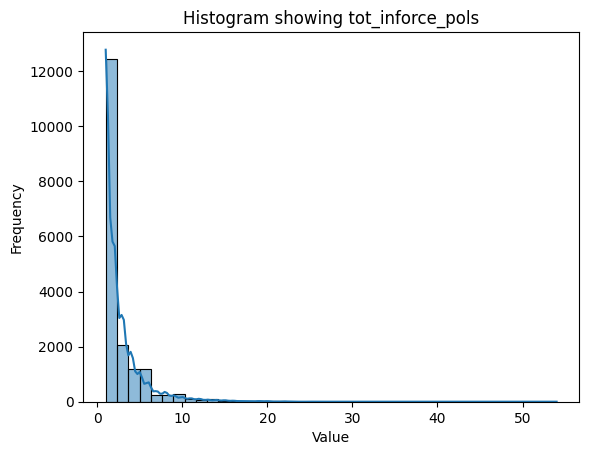

In [227]:
def draw_totinforce_boxplot():
    sns.boxplot(data=df['tot_inforce_pols'], orient="h")
    plt.xlabel('tot_inforce_pols')
    plt.show()
draw_totinforce_boxplot()

**Use of Chi Square Test to determine association between categorical variables**

From conducting Chi-squared tests, it can be seen that there is association between ‘f_purchase_lh’ and the variables ‘annual_income_est’, 'flg_has_health_claim', and 'flg_has_life_claim', as their p-values are smaller than 0.05. Thus, at 5% level of significance, we reject the null hypothesis that there is no association between the variables.


In [ ]:
chi_square_test(df, 'f_purchase_lh', 'annual_income_est')
chi_square_test(df, 'f_purchase_lh', 'flg_has_health_claim')
chi_square_test(df, 'f_purchase_lh', 'flg_has_life_claim')

## 2.3 Multivariate Analysis

From the density plot below, it can be seen that the fewer months since the customer last bought products, the more likely they are to purchase life or health insurance products in the next 3 months.

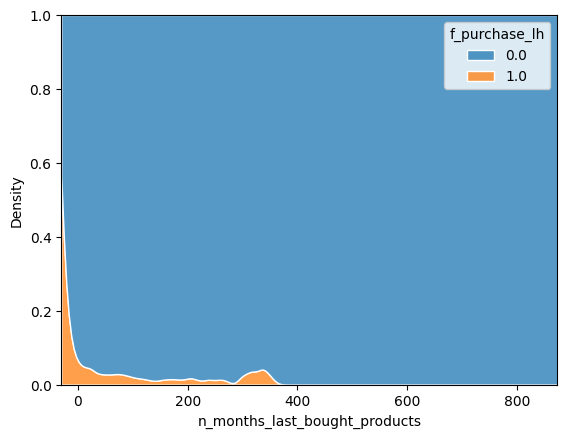

In [228]:
density_plot("n_months_last_bought_products", "f_purchase_lh")

For e22a6a, there is a high correlation between the Annual Premium Equivalent and the premium customers will pay from product inception to product maturity, as seen from the high correlation coeeficient of 0.998. In addition, as seen from the scatter plot with hue, as the Annual Premium Equivalent and premium increases, the less likely the customer is to purchase life or health insurance products within the next three months.



Correlation between prempaid_e22a6a and ape_e22a6a: 0.9984282630336253


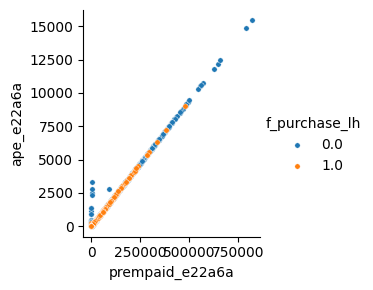

In [229]:
scatter_plot_with_hue('prempaid_e22a6a', 'ape_e22a6a','f_purchase_lh')
correlate('prempaid_e22a6a', 'ape_e22a6a')

As the number of in-force policies increases, the number of months since last buying a product decreases. In addition, as seen from the scatter plot with hue, those who are likely to purchase life or health insurance products within the next three months have a larger number of in-force policies and lower number of months since last buying a product.

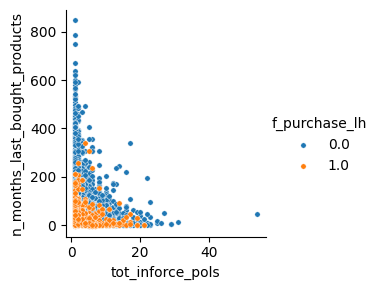

In [230]:
scatter_plot_with_hue('tot_inforce_pols', 'n_months_last_bought_products', 'f_purchase_lh')

# 3 Feature Engineering

## 3.1 One Hot Encoding
For categorical variables

In [231]:
nominal_cols_to_encode = ["race_desc", "ctrycode_desc", "clttype", "stat_flag", "cltsex_fix"]
try:
    df = pd.get_dummies(df, columns = nominal_cols_to_encode)
except:
    print("Already done!")


## 3.2 Ordinal Encoding
For ordinal variables

In [232]:
#Make income estimate an ordinal variable
encoder = OrdinalEncoder(categories=[['E.BELOW30K', 'D.30K-60K', 'C.60K-100K', 'B.100K-200K', 'A.ABOVE200K']])
df["annual_income_est"] = encoder.fit_transform(df[["annual_income_est"]])

## 3.3 Datetime Encoding
For datetime variables, encode by months: Earliest date is 0, any subsequent month adds 1 to the value

In [233]:
earliest_dob = min(df["cltdob_fix"])
df["cltdob_fix"] = (df["cltdob_fix"] - earliest_dob).dt.total_seconds() / (30 * 24 * 60 * 60)

earliest_occ_date = min(df["min_occ_date"])
df["min_occ_date"] = (df["min_occ_date"] - earliest_occ_date).dt.total_seconds() / (30 * 24 * 60 * 60)

# 4 Modelling 

## 4.1 Scaling
Scale the variables to be between the values of 0 and 1

In [234]:
def scale(df):
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df)
    col_names = df.columns.tolist()
    df = pd.DataFrame(scaled_df, columns = col_names)
    return df

df = scale(df)

## 4.2 Create Training and Test Data Set
Train/Test split of 80/20

In [235]:
y_data = df["f_purchase_lh"]
X_data = df.drop(["f_purchase_lh"], axis = 1)

In [236]:
# Make training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.20, random_state = RANDOM_STATE)

## 4.3 Initial Model Building

**Steps**
- Run Desired Model First
- Do feature selection + SMOTE after
- Check if feature selection + SMOTE are helpful
- Tune the models

**Models**
1. Logistic regression
2. Support vector machine
3. Random Forest
4. xgBoost
5. Neural Network

In [237]:
#Function for evaluating the performance of the model
def evaluate_model(predictions, actual = y_test):
    print(classification_report(y_test, predictions, digits=4))
    print("AUC: " + str(round(roc_auc_score(y_test, predictions), 4)) + "\n")
    print(pd.DataFrame(confusion_matrix(y_test, predictions), columns = ["Pred 0", "Pred 1"], index = ["True 0", "True 1"]))


### 4.3.1 Logistic Regression

#### Model Creation

In [238]:
logreg_model = LogisticRegression(max_iter = 1000, random_state = RANDOM_STATE)
logreg_model.fit(X_train, y_train)
logreg_pred = logreg_model.predict(X_test)

#### Evaluation Metrics

In [239]:
evaluate_model(logreg_pred)

              precision    recall  f1-score   support

         0.0     0.9621    0.9994    0.9804      3455
         1.0     0.8000    0.0556    0.1039       144

    accuracy                         0.9617      3599
   macro avg     0.8811    0.5275    0.5422      3599
weighted avg     0.9556    0.9617    0.9453      3599

AUC: 0.5275

        Pred 0  Pred 1
True 0    3453       2
True 1     136       8


### 4.3.2 Support Vector Machine

#### Model Creation

In [240]:
svm_model = LinearSVC(dual=False, max_iter=3000, random_state=RANDOM_STATE)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

#### Evaluation Metrics

In [241]:
evaluate_model(svm_pred)

              precision    recall  f1-score   support

         0.0     0.9600    0.9997    0.9794      3455
         1.0     0.0000    0.0000    0.0000       144

    accuracy                         0.9597      3599
   macro avg     0.4800    0.4999    0.4897      3599
weighted avg     0.9216    0.9597    0.9403      3599

AUC: 0.4999

        Pred 0  Pred 1
True 0    3454       1
True 1     144       0


### 4.3.3 Random Forest

#### Model Creation

In [242]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

#### Evaluation Metrics

In [243]:
evaluate_model(rf_pred)

              precision    recall  f1-score   support

         0.0     0.9600    0.9994    0.9793      3455
         1.0     0.0000    0.0000    0.0000       144

    accuracy                         0.9594      3599
   macro avg     0.4800    0.4997    0.4896      3599
weighted avg     0.9216    0.9594    0.9401      3599

AUC: 0.4997

        Pred 0  Pred 1
True 0    3453       2
True 1     144       0


### 4.3.4 xgBoost

#### Model Creation

In [244]:
xgboost_model = XGBClassifier(random_state = RANDOM_STATE)
xgboost_model.fit(X_train, y_train)
xgboost_pred = xgboost_model.predict(X_test)

#### Evaluation Metrics

In [245]:
evaluate_model(xgboost_pred)

              precision    recall  f1-score   support

         0.0     0.9649    0.9948    0.9796      3455
         1.0     0.5135    0.1319    0.2099       144

    accuracy                         0.9603      3599
   macro avg     0.7392    0.5634    0.5948      3599
weighted avg     0.9468    0.9603    0.9488      3599

AUC: 0.5634

        Pred 0  Pred 1
True 0    3437      18
True 1     125      19


### 4.3.5 Neural Network

#### Model Creation

In [246]:
#Hyperparameters and settings
learning_rate = 0.01
loss_function = tf.keras.losses.binary_crossentropy
optimiser_function = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tf.random.set_seed(RANDOM_STATE)

In [247]:
#Model setup
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation = "relu"), #Hidden 1
    tf.keras.layers.Dense(8, activation = "relu"), #Hidden 2
    tf.keras.layers.Dense(1, activation = "sigmoid") #Output
])

In [248]:
nn_model.compile(
    loss = loss_function,
    optimizer = optimiser_function,
    metrics=[
        tf.keras.metrics.F1Score(name="f1score"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision")
    ]
)

In [249]:
#Train model
nn_model.fit(X_train, y_train, epochs=50)

# Make predictions
nn_pred_raw = nn_model.predict(X_test)
nn_pred = [1 if prob > 0.5 else 0 for prob in np.ravel(nn_pred_raw)]

Epoch 1/50


450/450 [==============================] - 1s 1ms/step - loss: 0.1529 - f1score: 0.0757 - accuracy: 0.9602 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 2/50
450/450 [==============================] - 1s 1ms/step - loss: 0.1445 - f1score: 0.0757 - accuracy: 0.9607 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 3/50
450/450 [==============================] - 1s 1ms/step - loss: 0.1401 - f1score: 0.0757 - accuracy: 0.9607 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 4/50
450/450 [==============================] - 1s 1ms/step - loss: 0.1399 - f1score: 0.0757 - accuracy: 0.9607 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 5/50
450/450 [==============================] - 1s 1ms/step - loss: 0.1361 - f1score: 0.0757 - accuracy: 0.9607 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 6/50
450/450 [==============================] - 0s 1ms/step - loss: 0.1377 - f1score: 0.0757 - accuracy: 0.9607 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 7/50
450/450 [=============

#### Evaluation Metrics

In [250]:
evaluate_model(nn_pred)

              precision    recall  f1-score   support

         0.0     0.9644    0.9887    0.9764      3455
         1.0     0.3158    0.1250    0.1791       144

    accuracy                         0.9542      3599
   macro avg     0.6401    0.5569    0.5778      3599
weighted avg     0.9385    0.9542    0.9445      3599

AUC: 0.5569

        Pred 0  Pred 1
True 0    3416      39
True 1     126      18


# 5 Feature Selection

## 5.1 Random Forest
We use the importance values from the random forest model created earlier to do feature selection. In our case, we choose to keep the top 40 variables by importance. 

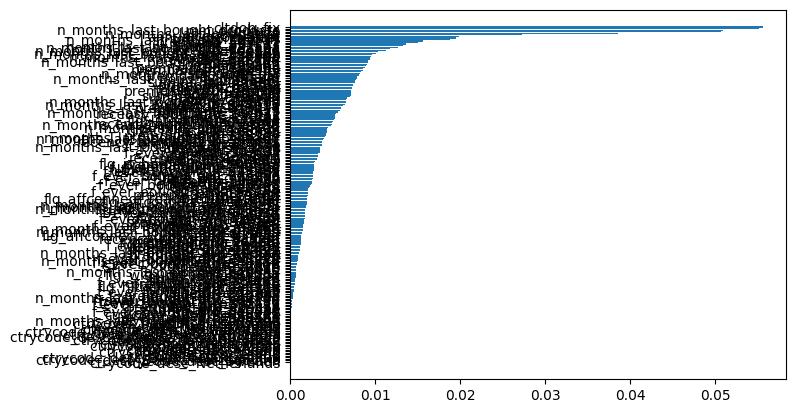

In [251]:
# Plot RF importance scores
rf_importances = rf_model.feature_importances_
sorted_idx = rf_importances.argsort()
plt.barh(rf_model.feature_names_in_[sorted_idx], rf_importances[sorted_idx])
plt.show()

In [252]:
#Select top 40
num_features = 40
rf_selected_features = list(rf_model.feature_names_in_[sorted_idx][:-(num_features+1):-1])
rf_selected_features

['cltdob_fix',
 'n_months_last_bought_products',
 'min_occ_date',
 'hh_size',
 'n_months_last_bought_gi',
 'recency_lapse',
 'annual_income_est',
 'tot_inforce_pols',
 'n_months_last_bought_507c37',
 'prempaid_507c37',
 'ape_507c37',
 'sumins_507c37',
 'n_months_last_bought_e22a6a',
 'n_months_last_bought_lh_e22a6a',
 'f_ever_bought_gi',
 'n_months_last_bought_grp_70e1dd',
 'ape_e22a6a',
 'n_months_last_bought_grp_1581d7',
 'ape_ltc_43b9d5',
 'n_months_last_bought_839f8a',
 'prempaid_e22a6a',
 'is_valid_dm',
 'n_months_last_bought_ltc_43b9d5',
 'giclaim_amt',
 'ape_lh_e22a6a',
 'prempaid_ltc',
 'prempaid_lh_e22a6a',
 'prempaid_ltc_43b9d5',
 'ape_ltc',
 'is_class_1_2',
 'n_months_last_bought_ltc',
 'prempaid_lh_f852af',
 'flg_gi_claim',
 'n_months_last_bought_lh_f852af',
 'sumins_ltc',
 'sumins_ltc_43b9d5',
 'ape_839f8a',
 'prempaid_839f8a',
 'sumins_lh_f852af',
 'is_consent_to_sms']

## 5.2 Forward Selection
It would also be possible to do the same with forward selection, with gradient boosting (as done here), or other models such as logistic regression. However, due to computing power constraints, we decided not to. 

In [253]:
def forward_selection():
    base_model = XGBClassifier(random_state = RANDOM_STATE)
    sfs = SequentialFeatureSelector(base_model, k_features=num_features, forward=True, scoring='f1')
    sfs.fit(X_train, y_train)

    selected_features_indices = sfs.k_feature_idx_

    X_train_selected = X_train[:, selected_features_indices]
    X_test_selected = X_test[:, selected_features_indices]

    final_model = base_model.fit(X_train_selected, y_train)
    y_pred = final_model.predict(X_test_selected)

    evaluate_model(y_pred)
    
#forward_selection()


# 6 Refactoring Dataset
We choose to use the feature selection from Random Forest.

In [254]:
X_train = X_train[rf_selected_features]
X_test = X_test[rf_selected_features]

## 6.1 Balancing the Dataset
Using SMOTE to ensure that the dataset is balanced, with the number of observations in the positive and negative class.

In [255]:
sm = SMOTE(random_state=RANDOM_STATE, sampling_strategy= 1.0)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
y_SMOTE.value_counts()

f_purchase_lh
0.0    13827
1.0    13827
Name: count, dtype: int64

# 7 Final Models
After feature selection and balancing, run the models again and tune their hyperparameters

## 7.1 Logistic Regression

### After Feature Selection

In [256]:
fs_logreg_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
fs_logreg_model.fit(X_train, y_train)
fs_logreg_model_pred = fs_logreg_model.predict(X_test)
evaluate_model(fs_logreg_model_pred) 

              precision    recall  f1-score   support

         0.0     0.9602    0.9991    0.9793      3455
         1.0     0.2500    0.0069    0.0135       144

    accuracy                         0.9594      3599
   macro avg     0.6051    0.5030    0.4964      3599
weighted avg     0.9318    0.9594    0.9406      3599

AUC: 0.503

        Pred 0  Pred 1
True 0    3452       3
True 1     143       1


### After Smote

In [257]:
smote_logreg_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
smote_logreg_model.fit(X_SMOTE, y_SMOTE)
smote_logreg_model_pred = smote_logreg_model.predict(X_test)
evaluate_model(smote_logreg_model_pred) 

              precision    recall  f1-score   support

         0.0     0.9808    0.7233    0.8326      3455
         1.0     0.0904    0.6597    0.1590       144

    accuracy                         0.7208      3599
   macro avg     0.5356    0.6915    0.4958      3599
weighted avg     0.9451    0.7208    0.8056      3599

AUC: 0.6915

        Pred 0  Pred 1
True 0    2499     956
True 1      49      95


### After Tuning

In [258]:
# Defining the hyperparameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver' : ['newton-cg', 'lbfgs']
}

# Initialising the  logistic regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Grid Search
grid_search = GridSearchCV(estimator=logreg_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_SMOTE, y_SMOTE)

# Obtaining the best parameters and best estimater
logreg_best_params = grid_search.best_params_
print(logreg_best_params)
logreg_best_estimator = grid_search.best_estimator_

# Making predictions on the test set using the logistic regression model that has been tuned via grid search
tuned_logreg_pred = logreg_best_estimator.predict(X_test)

# Evaluating the model
evaluate_model(tuned_logreg_pred)


{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

         0.0     0.9807    0.7213    0.8312      3455
         1.0     0.0898    0.6597    0.1581       144

    accuracy                         0.7188      3599
   macro avg     0.5353    0.6905    0.4946      3599
weighted avg     0.9451    0.7188    0.8043      3599

AUC: 0.6905

        Pred 0  Pred 1
True 0    2492     963
True 1      49      95


## 7.2 Support Vector Machine

### After Feature Selection

In [259]:
fs_svm_model = LinearSVC(dual=False, max_iter=3000, random_state=RANDOM_STATE)
fs_svm_model.fit(X_train, y_train)
fs_svm_pred = fs_svm_model.predict(X_test)
evaluate_model(fs_svm_pred)

              precision    recall  f1-score   support

         0.0     0.9600    1.0000    0.9796      3455
         1.0     0.0000    0.0000    0.0000       144

    accuracy                         0.9600      3599
   macro avg     0.4800    0.5000    0.4898      3599
weighted avg     0.9216    0.9600    0.9404      3599

AUC: 0.5

        Pred 0  Pred 1
True 0    3455       0
True 1     144       0


c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### After SMOTE

In [260]:
smote_svm_model = LinearSVC(dual=False, max_iter=3000, random_state=RANDOM_STATE)
smote_svm_model.fit(X_SMOTE, y_SMOTE)
smote_svm_pred = smote_svm_model.predict(X_test)
evaluate_model(smote_svm_pred)

              precision    recall  f1-score   support

         0.0     0.9818    0.7187    0.8299      3455
         1.0     0.0916    0.6806    0.1614       144

    accuracy                         0.7171      3599
   macro avg     0.5367    0.6996    0.4957      3599
weighted avg     0.9462    0.7171    0.8031      3599

AUC: 0.6996

        Pred 0  Pred 1
True 0    2483     972
True 1      46      98


### After Tuning

In [261]:
#Tuning
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge']
}

# Grid search
tuned_svm_grid = GridSearchCV(LinearSVC(dual=False, max_iter=3000, random_state=RANDOM_STATE), svm_param_grid, scoring = 'f1_macro')
tuned_svm_grid.fit(X_SMOTE, y_SMOTE)
print(tuned_svm_grid.best_params_)

c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

{'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}


c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\yeosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yeosh\AppDa

In [262]:
svm_best_estimator = tuned_svm_grid.best_estimator_
tuned_svm_pred = svm_best_estimator.predict(X_test)
evaluate_model(tuned_svm_pred)

              precision    recall  f1-score   support

         0.0     0.9812    0.7262    0.8347      3455
         1.0     0.0921    0.6667    0.1619       144

    accuracy                         0.7238      3599
   macro avg     0.5367    0.6964    0.4983      3599
weighted avg     0.9457    0.7238    0.8077      3599

AUC: 0.6964

        Pred 0  Pred 1
True 0    2509     946
True 1      48      96


## 7.3 Random Forest

### After Feature Selection

In [263]:
fs_rf_model = RandomForestClassifier(random_state = RANDOM_STATE)
fs_rf_model.fit(X_train, y_train)
fs_rf_pred = fs_rf_model.predict(X_test)
evaluate_model(fs_rf_pred)

              precision    recall  f1-score   support

         0.0     0.9605    0.9994    0.9796      3455
         1.0     0.5000    0.0139    0.0270       144

    accuracy                         0.9600      3599
   macro avg     0.7303    0.5067    0.5033      3599
weighted avg     0.9421    0.9600    0.9415      3599

AUC: 0.5067

        Pred 0  Pred 1
True 0    3453       2
True 1     142       2


### After SMOTE

In [268]:
smote_rf_model = RandomForestClassifier(random_state = RANDOM_STATE)
smote_rf_model.fit(X_SMOTE, y_SMOTE)
smote_rf_pred = smote_rf_model.predict(X_test)
evaluate_model(smote_rf_pred)

              precision    recall  f1-score   support

         0.0     0.9675    0.9740    0.9707      3455
         1.0     0.2562    0.2153    0.2340       144

    accuracy                         0.9436      3599
   macro avg     0.6119    0.5946    0.6023      3599
weighted avg     0.9390    0.9436    0.9412      3599

AUC: 0.5946

        Pred 0  Pred 1
True 0    3365      90
True 1     113      31


### After Tuning

In [ ]:
# Tuning
rf_params = {
    'n_estimators': [100, 300, 500],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 3, 5]
}
# perform grid search and then fit
tuned_rf_model = GridSearchCV(RandomForestClassifier(random_state = RANDOM_STATE), rf_params, scoring = 'f1_macro')
tuned_rf_model.fit(X_SMOTE, y_SMOTE)
print(tuned_rf_model.best_params_)

In [ ]:
rf_best_estimator = tuned_rf_model.best_estimator_
tuned_rf_pred = rf_best_estimator.predict(X_test)
evaluate_model(tuned_rf_pred)

## 7.4 xgBoost

### After Feature Selection

In [285]:
fs_xgboost_model = XGBClassifier(random_state = RANDOM_STATE)
fs_xgboost_model.fit(X_train, y_train)
fs_xgboost_pred = fs_xgboost_model.predict(X_test)
evaluate_model(fs_xgboost_pred)


              precision    recall  f1-score   support

         0.0     0.9632    0.9933    0.9781      3455
         1.0     0.3611    0.0903    0.1444       144

    accuracy                         0.9572      3599
   macro avg     0.6622    0.5418    0.5613      3599
weighted avg     0.9391    0.9572    0.9447      3599

AUC: 0.5418

        Pred 0  Pred 1
True 0    3432      23
True 1     131      13


### After SMOTE

In [286]:
smote_xgboost_model = XGBClassifier(random_state = RANDOM_STATE)
smote_xgboost_model.fit(X_SMOTE, y_SMOTE)
smote_xgboost_pred = smote_xgboost_model.predict(X_test)
evaluate_model(smote_xgboost_pred)

              precision    recall  f1-score   support

         0.0     0.9641    0.9792    0.9716      3455
         1.0     0.2000    0.1250    0.1538       144

    accuracy                         0.9450      3599
   macro avg     0.5820    0.5521    0.5627      3599
weighted avg     0.9335    0.9450    0.9389      3599

AUC: 0.5521

        Pred 0  Pred 1
True 0    3383      72
True 1     126      18


### After Tuning

In [ ]:
# Create the grid
xgboost_params = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [8, 10, 12],
    'gamma': [0, 0.2, 0.4],
    'eta': [0.1],
    'min_child_weight': [1, 3, 5]
}

# Grid Search
tuned_xgboost_model = GridSearchCV(XGBClassifier(random_state = RANDOM_STATE), xgboost_params, scoring = 'f1_macro')
tuned_xgboost_model.fit(X_SMOTE, y_SMOTE)
print(tuned_xgboost_model.best_params_)

In [ ]:
xgboost_best_estimator = tuned_xgboost_model.best_estimator_
tuned_xgboost_pred = xgboost_best_estimator.predict(X_test)
evaluate_model(tuned_xgboost_pred)

## 7.5 Neural Network

### After Feature Selection

In [283]:
#Hyperparameters and settings
learning_rate = 0.01
loss_function = tf.keras.losses.binary_crossentropy
optimiser_function = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tf.random.set_seed(RANDOM_STATE)

#Model setup
fs_nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = "relu"), #Hidden 1
    tf.keras.layers.Dense(16, activation = "relu"), #Hidden 2
    tf.keras.layers.Dense(1, activation = "sigmoid") #Output
])

fs_nn_model.compile(
    loss = loss_function,
    optimizer = optimiser_function,
    metrics=[
        tf.keras.metrics.F1Score(name="f1score"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision")
    ]
)

#Train model
fs_nn_model.fit(X_train, y_train, epochs=50, verbose = 0)

# Make predictions
fs_nn_pred_raw = fs_nn_model.predict(X_test)
fs_nn_pred = [1 if prob > 0.5 else 0 for prob in np.ravel(fs_nn_pred_raw)]

#Evaluation
evaluate_model(fs_nn_pred)

113/113 [==============================] - 0s 813us/step
              precision    recall  f1-score   support

         0.0     0.9625    0.9954    0.9787      3455
         1.0     0.3846    0.0694    0.1176       144

    accuracy                         0.9583      3599
   macro avg     0.6736    0.5324    0.5482      3599
weighted avg     0.9394    0.9583    0.9442      3599

AUC: 0.5324

        Pred 0  Pred 1
True 0    3439      16
True 1     134      10


### After SMOTE

In [282]:
#Hyperparameters and settings
learning_rate = 0.01
loss_function = tf.keras.losses.binary_crossentropy
optimiser_function = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tf.random.set_seed(RANDOM_STATE)

#Model setup
smote_nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = "relu"), #Hidden 1
    tf.keras.layers.Dense(16, activation = "relu"), #Hidden 2
    tf.keras.layers.Dense(1, activation = "sigmoid") #Output
])

smote_nn_model.compile(
    loss = loss_function,
    optimizer = optimiser_function,
    metrics=[
        tf.keras.metrics.F1Score(name="f1score"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision")
    ]
)

#Train model
smote_nn_model.fit(X_SMOTE, y_SMOTE, epochs=50, verbose = 0)

# Make predictions
smote_nn_pred_raw = smote_nn_model.predict(X_test)
smote_nn_pred = [1 if prob > 0.5 else 0 for prob in np.ravel(smote_nn_pred_raw)]

#Evaluation
evaluate_model(smote_nn_pred)

113/113 [==============================] - 0s 865us/step
              precision    recall  f1-score   support

         0.0     0.9694    0.8336    0.8964      3455
         1.0     0.0844    0.3681    0.1373       144

    accuracy                         0.8149      3599
   macro avg     0.5269    0.6008    0.5168      3599
weighted avg     0.9340    0.8149    0.8660      3599

AUC: 0.6008

        Pred 0  Pred 1
True 0    2880     575
True 1      91      53


### After Tuning
Due to computing power constraints, we did not carry out Grid Search for neural networks. Instead, we arbitrarily changed values for various hyperparameters until we found a better performing model. 
With more time and computing power, GridSearchCV can be done to determine the activation functions, number of nodes, and the loss function hyperparameters. 

In [284]:
#Hyperparameters and settings
learning_rate = 0.01
loss_function = tf.keras.losses.binary_crossentropy
optimiser_function = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tf.random.set_seed(RANDOM_STATE)

#Model setup
tuned_nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = "relu"), #Hidden 1
    tf.keras.layers.Dense(1, activation = "sigmoid") #Output
])

tuned_nn_model.compile(
    loss = loss_function,
    optimizer = optimiser_function,
    metrics=[
        tf.keras.metrics.F1Score(name="f1score"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision")
    ]
)

#Train model
tuned_nn_model.fit(X_SMOTE, y_SMOTE, epochs=50, verbose = 0)

# Make predictions
tuned_nn_pred_raw = tuned_nn_model.predict(X_test)
tuned_nn_pred = [1 if prob > 0.5 else 0 for prob in np.ravel(tuned_nn_pred_raw)]

#Evaluation
evaluate_model(tuned_nn_pred)

113/113 [==============================] - 0s 810us/step
              precision    recall  f1-score   support

         0.0     0.9710    0.7933    0.8732      3455
         1.0     0.0799    0.4306    0.1348       144

    accuracy                         0.7788      3599
   macro avg     0.5254    0.6119    0.5040      3599
weighted avg     0.9353    0.7788    0.8437      3599

AUC: 0.6119

        Pred 0  Pred 1
True 0    2741     714
True 1      82      62


# 8 Final Comparisons and Conclusion

## 8.1 Performance Table
All values are given as macro average of f1-scores

| Model | Initial | Feature Selection | SMOTE | Tuning | 
| --- | --- | --- | --- | --- |
| Logistic Regression | 0.5422 | 0.4964 | 0.4958 | 0.4946 |
| Support Vector Machine | 0.4897 | 0.4898 | 0.4957 | 0.4983 |
| Random Forest | 0.4896 | 0.5033 | 0.6023 | 0.6292 |
| XGBoost | 0.5948 | 0.5613 | 0.5627 | 0.6103 |
| Neural Network | 0.5778 | 0.5482 | 0.5168 | 0.5040 |

## 8.2 Analysis
### Overall Performances
- Overall, the performance as measured by the macro average f1 metric is rather poor, with all models not going above 0.65.
- Models generally performed well for true negatives, with high True Negative Rates (TNR). However, this is not the same for True Positive Rates. All models correctly predicted a True Positive less than half the time, a rather abysmal rate. 

### Improvement Methods
- Feature selection improved various models, notably the tree based models such as Random Forest and XGBoost. The other models deproved.
- After SMOTE, Random Forest had a massive increase in performance, while the others had slight increases or decreases. 
- Unfortunately, tuning the models did not result in significant performance increases. Only Random Forest and XGBoost had a notable improvement. 

## 8.3 Conclusion
We conclude that the best model to use is Random Forest. However, it would not be reliable predictor of true positives. 

## 8.4 Improvements
- Better cleaning of the dataset or a higher quality dataset. Currently, it contains numerous Null values unaccounted for, which we had to fix based on our best judgement. 
- More time or computing power, for model training and tuning. 
- Used a metric focused on True Positives instead of a overall metric, since those are customers that would generate revenue for the company.

# 9 Appendix

## 9.1 Testing for Multicollinearity

Category 1: Client Risk and Status Indicators

In [ ]:
# CONCLUSION: low multicollinearity; keep all 10 features
client_risk_status_indicators_features = ["flg_substandard",
                                          "flg_is_borderline_standard",
                                          "flg_is_revised_term",
                                          "flg_is_rental_flat",
                                          "flg_has_health_claim",
                                          "flg_has_life_claim",
                                          "flg_gi_claim",
                                          "flg_is_proposal",
                                          "flg_with_preauthorisation",
                                          "flg_is_returned_mail"]

cat1_features_to_test = []

for col in df.columns:
    if col in client_risk_status_indicators_features:
        cat1_features_to_test.append(col)

In [ ]:
cat1_correlation_matrix = df[cat1_features_to_test].corr()

sns.heatmap(cat1_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X = df[cat1_features_to_test]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

Category 2: Client Consent and Communication Preferences


In [ ]:
# CONCLUSION: moderate multicollinearity for features is_consent_to_mail, is_consent_to_email
client_consent_and_communication_features = ["is_consent_to_mail",
                                             "is_consent_to_email",
                                             "is_consent_to_call",
                                             "is_consent_to_sms",
                                             "is_valid_dm",
                                             "is_valid_email"]

cat2_features_to_test = []

for col in df.columns:
    if col in client_consent_and_communication_features:
        cat2_features_to_test.append(col)

In [ ]:
cat2_correlation_matrix = df[cat2_features_to_test].corr()

sns.heatmap(cat2_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X = df[cat2_features_to_test]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

Category 3: Demographic and Household Information

In [ ]:
# CONCLUSION
# High multicollinearity: is_sg_pr, hh_20, pop_20, hh_size
# However, since hh_size is highly correlated with hh_size_est and hh_size_est is in need of conversion, 
# we keep hh_size and drop hh_size_est
demographic_household_info_features = ["is_housewife_retiree",
                                       "is_sg_pr",
                                       "is_class_1_2",
                                       "is_dependent_in_at_least_1_policy",
                                       "hh_20",
                                       "pop_20",
                                       "hh_size",
                                       "hh_size_est",
                                       "annual_income_est"]

cat3_features_to_test = []

for col in df.columns:
    if col in demographic_household_info_features:
        cat3_features_to_test.append(col)

In [ ]:
cat3_correlation_matrix = df[cat3_features_to_test].corr()

sns.heatmap(cat3_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X = df[cat3_features_to_test]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

Category 4: Policy and Claim History


In [ ]:
# CONCLUSION: all low multicollinearity; keep all
policy_and_claim_history_features = ["n_months_last_bought_products",
                                     "flg_latest_being_lapse",
                                     "flg_latest_being_cancel",
                                     "recency_lapse",
                                     "recency_cancel",
                                     "tot_inforce_pols",
                                     "tot_cancel_pols",
                                     "f_ever_declined_la"]

cat4_features_to_test = []

for col in df.columns:
    if col in policy_and_claim_history_features:
        cat4_features_to_test.append(col)

In [ ]:
cat4_correlation_matrix = df[cat4_features_to_test].corr()

sns.heatmap(cat4_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
X = df[cat4_features_to_test]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

Category 5: Other Flags and Metrics


In [ ]:
# CONCLUSION: remove recency_hlthclaim, recency_giclaim
other_flags_and_metrics_features = ["f_elx",
                                    "f_mindef_mha",
                                    "f_retail",
                                    "flg_affconnect_show_interest_ever",
                                    "flg_affconnect_ready_to_buy_ever",
                                    "flg_affconnect_lapse_ever",
                                    "affcon_visit_days",
                                    "n_months_since_visit_affcon",
                                    "clmcon_visit_days",
                                    "recency_clmcon",
                                    "recency_clmcon_regis",
                                    "hlthclaim_amt",
                                    "giclaim_amt",
                                    "recency_hlthclaim",
                                    "recency_giclaim",
                                    "hlthclaim_cnt_success",
                                    "giclaim_cnt_success"]

cat5_features_to_test = []

for col in df.columns:
    if col in other_flags_and_metrics_features:
        cat5_features_to_test.append(col)

In [ ]:
# Flags possibly related to client's association with specific programs or sectors.
X = df[["f_elx", "f_mindef_mha", "f_retail"]]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

In [ ]:
# Metrics related to client’s activity in affinity connect
X = df[["flg_affconnect_show_interest_ever", "flg_affconnect_ready_to_buy_ever", "flg_affconnect_lapse_ever", "affcon_visit_days", "n_months_since_visit_affcon"]]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

In [ ]:
# Metrics related to client’s activity in claim connect
X = df[["clmcon_visit_days", "recency_clmcon", "recency_clmcon_regis"]]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

In [ ]:
# Health and general insurance claim-related metrics
X = df[["hlthclaim_amt", "giclaim_amt", "recency_hlthclaim", "recency_giclaim", "hlthclaim_cnt_success"]]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("VIF Data:")
print(vif_data)

## 9.2 Replacing NaN values from Race with proportion

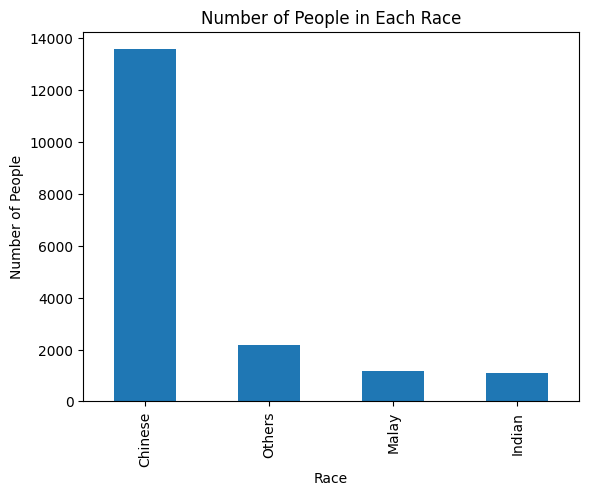

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def replace_with_proportion(frame, column):
     isnull = frame[column].isnull()
     sample = frame[column].dropna()
     sample=set(sample)
     countframe=pd.DataFrame(columns=["name", "count", "proportion"])
     for x in sample:
          countframe.loc[-1] = [x,frame.loc[frame[column] == x].shape[0], 0 ]
          countframe.index = countframe.index + 1
     countframe['proportion']=countframe['count']/countframe['count'].sum()
     to_fill=np.random.choice(countframe['name'], size=(frame[column].isnull().sum(),), p=countframe['proportion'])
     frame.loc[isnull, column] = to_fill
     return frame


data = pd.read_parquet('catB_train.parquet')

# Apply the function to replace NaN values
data = replace_with_proportion(data, 'race_desc')

# Count occurrences of each race description after replacing NaN values
race_counts = data['race_desc'].value_counts()

# Plot the data
race_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Race')
plt.ylabel('Number of People')
plt.title('Number of People in Each Race')

# Show the plot
plt.show()




As the correlation between hh_size and hh_size_est was found to be high (~0.955), the column hh_size_est was dropped.

4.83302457707699


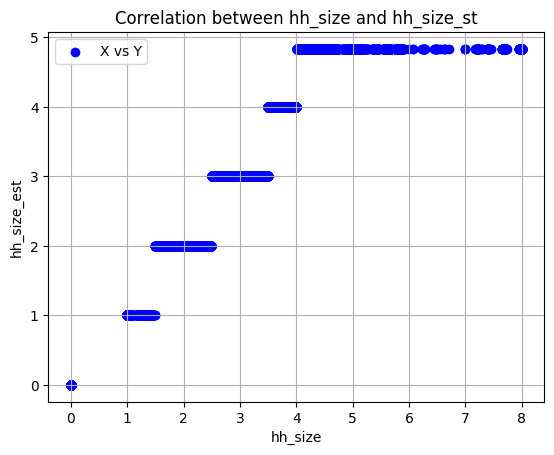

KeyError: 'hh_size_est'

In [ ]:
df_copy = data.copy()

size_counts = df_copy['hh_size'].value_counts(dropna=False)

# replace est_size_counts >4 with average of others

filtered_values = size_counts[size_counts.index > 4].index

# Filter the DataFrame based on the condition
filtered_df = df_copy[df_copy['hh_size'].isin(filtered_values)]

# Replace >4 values in hh_size_est with average of the filtered values
average_of_filtered_values = filtered_df['hh_size'].mean()

print(average_of_filtered_values)

df_copy['hh_size_est'].replace('>4', f'{average_of_filtered_values}', inplace=True)

for i in range(5):
  df_copy['hh_size_est'].replace(f'{i}', i, inplace=True)

# replace NaN values with 0
df_copy['hh_size'] = df_copy['hh_size'].fillna(0)
df_copy['hh_size_est'] = df_copy['hh_size_est'].fillna(0)
# df['hh_size'].fillna(0, inplace = True)
# df['hh_size_est'].fillna(0, inplace = True)

# find correlation between hh_size_est and hh_size
est_size_counts = df_copy['hh_size_est'].value_counts(dropna=False)
size_counts = df_copy['hh_size'].value_counts(dropna=False)

x = df_copy['hh_size']
y = df_copy['hh_size_est']

plt.scatter(x, y, color='blue', label='X vs Y')

# Add labels and title
plt.xlabel('hh_size')
plt.ylabel('hh_size_est')
plt.title('Correlation between hh_size and hh_size_st')

# Show plot
plt.grid(True)
plt.legend()
plt.show()

correlation = df['hh_size'].corr(df['hh_size_est'])

print("Correlation between 'hh_size' and 'hh_size_est':", correlation)

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!